##### This task tries to apply VGG16 and ResNet50 on **"cifar100"** data valuate the models.


In [147]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as piv
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input as pir
from tensorflow.keras.optimizers import Adamax
  
import numpy as np
import matplotlib.pyplot as plt
  
import warnings
warnings.filterwarnings('ignore')

In [148]:
#load the data cifar100 and Distribute it to train and test set
(X_train,Y_train), (X_test,Y_test)=cifar100.load_data()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


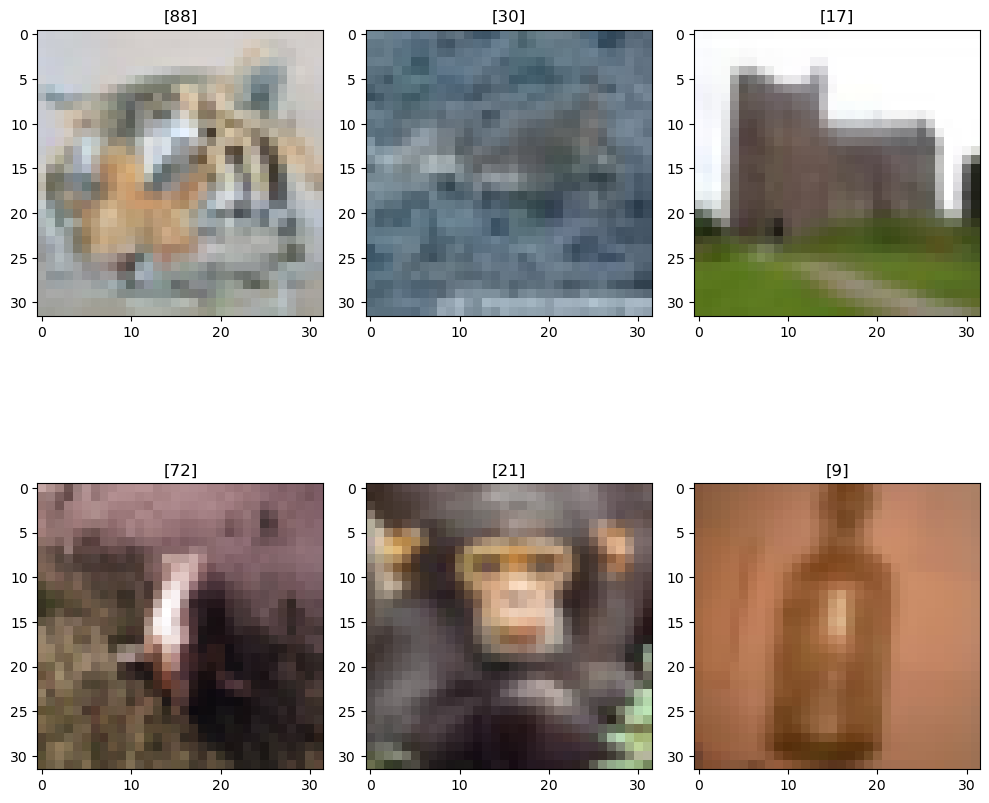

In [149]:
def show_samples(data, labels):
    plt.subplots(figsize=(10, 10))
    for i in range(6):
        plt.subplot(2,3,i+1)
        k=np.random.randint(0, data.shape[0])
        plt.title(labels[k])
        plt.imshow(data[k])
    plt.tight_layout()
    plt.show()
  
show_samples(X_train, Y_train)

In [150]:
#Normalize pixel values
X_train=X_train.astype("float32")/255.0
X_test=X_test.astype("float32")/255.0

'''#Resize images to 96*96(since VGG16 uses gigher image size)
#unable to resize..cpu crashing while buiding the model
X_train= tf.image.resize(X_train,(96, 96))
X_test= tf.image.resize(X_test, (96,96))'''

'#Resize images to 96*96(since VGG16 uses gigher image size)\n#unable to resize..cpu crashing while buiding the model\nX_train= tf.image.resize(X_train,(96, 96))\nX_test= tf.image.resize(X_test, (96,96))'

In [151]:
#Convert class vectors to one-hot encoding
num_classes=100 #since cifar100 has 100 class data
Y_train =keras.utils.to_categorical(Y_train,num_classes)
Y_test = keras.utils.to_categorical(Y_test,num_classes)

VGG16 model

In [152]:
model_vgg=VGG16(#transfer learning from vgg16
    include_top=False, #only have 100 classes
    weights='imagenet',
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=max,
    classes=100,
    classifier_activation='softmax'
)
model_vgg.trainable=False ## Not trainable weights

X_train=piv(X_train)
X_test=piv(X_test)

In [171]:
#on top of VGG16 multiple layers added
#4096,2048,1024
one=Flatten()(model_vgg.output)
two=Dense(256,activation='relu')(one)
n1=BatchNormalization()(two)
three=Dense(512,activation='relu')(n1)
d1=layers.Dropout(0.3)(three)
n2=BatchNormalization()(d1)
four=Dense(512,activation='relu')(n2)
d2=layers.Dropout(0.25)(four)
n3=BatchNormalization()(d2)
output=Dense(100,activation='softmax')(n3)

In [172]:
model_1=Model(inputs=model_vgg.input,outputs=output) #functional api method

In [173]:
#Compile the model
model_1.compile(loss="categorical_crossentropy", 
              optimizer="adamax", 
              metrics=["accuracy"])

In [174]:
print(model_1.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0  

In [175]:
#Train the model
ear_stp=EarlyStopping(monitor='val_accuracy',mode='max',patience=3,restore_best_weights=True)
batch_size=64
#due to the computation time I am limiting the no. of epochs to 5
epochs=5
model_hist=model_1.fit(X_train,Y_train, batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_test,Y_test),
                     callbacks=[ear_stp])

Epoch 1/10
782/782 [==============================] - 186s 236ms/step - loss: 4.3269 - accuracy: 0.0748 - val_loss: 7.2833 - val_accuracy: 0.0306
Epoch 2/10
782/782 [==============================] - 189s 242ms/step - loss: 3.9271 - accuracy: 0.1175 - val_loss: 6.8476 - val_accuracy: 0.0415
Epoch 3/10
782/782 [==============================] - 313s 400ms/step - loss: 3.7553 - accuracy: 0.1410 - val_loss: 7.8091 - val_accuracy: 0.0323
Epoch 4/10
782/782 [==============================] - 187s 239ms/step - loss: 3.6398 - accuracy: 0.1551 - val_loss: 11.6411 - val_accuracy: 0.0230
Epoch 5/10
782/782 [==============================] - 165s 211ms/step - loss: 3.5639 - accuracy: 0.1665 - val_loss: 7.8614 - val_accuracy: 0.0302


----------------------------------------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------------------------------------------

ResNet50

In [212]:
#load the data cifar100 and Distribute it to train and test set
(X_train,Y_train), (X_test,Y_test)=cifar100.load_data()

#Normalize pixel values
X_train=X_train.astype("float32")/255.0
X_test=X_test.astype("float32")/255.0

#Convert class vectors to one-hot encoding
num_classes=100 #since cifar100 has 100 class data
Y_train =keras.utils.to_categorical(Y_train,num_classes)
Y_test = keras.utils.to_categorical(Y_test,num_classes)

In [213]:

#pre-trained ResNet50 model without the top (fully connected) layers
model_rn=ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=max,
    classes=100
)
model_rn.trainable=False ## Not trainable weights

X_train=pir(X_train)
X_test=pir(X_test)

In [214]:
# Add custom fully connected layers on top of ResNet50
one=GlobalAveragePooling2D()(model_rn.output)
two=Dense(512,activation='relu')(one)
n1=BatchNormalization()(two)
three=Dense(256,activation='relu')(n1)
d1=layers.Dropout(0.3)(three)
n2=BatchNormalization()(d1)
output=Dense(100, activation='softmax')(n2)

In [215]:
# Create the new model with ResNet50 base and custom top layers
model_2=Model(inputs=model_rn.input, outputs=output)

In [216]:
#Compile the model
model_2.compile(loss='categorical_crossentropy',
              optimizer="adamax",#learning_rate=0.0001
              #adding the learning rate into compilation certainly increased the accuracy in validation set(not muxh but better than without lr), 
              # but the entire epoch time consumption was high. removed it beacuse of time limitation
              metrics=['accuracy'])

In [217]:
print(model_2.summary())

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [219]:
#Train the model
ear_stp=EarlyStopping(monitor='val_accuracy',mode='max',patience=3,restore_best_weights=True)
batch_size=64
#due to the high computation time I am limiting the no. of epochs to 5
epochs=5
model_hist=model_2.fit(X_train,Y_train,batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_test,Y_test),
                     callbacks=[ear_stp])

Epoch 1/5
782/782 [==============================] - 133s 170ms/step - loss: 4.2393 - accuracy: 0.0792 - val_loss: 5.7110 - val_accuracy: 0.0275
Epoch 2/5
782/782 [==============================] - 125s 160ms/step - loss: 3.8675 - accuracy: 0.1260 - val_loss: 7.3118 - val_accuracy: 0.0312
Epoch 3/5
782/782 [==============================] - 132s 169ms/step - loss: 3.6743 - accuracy: 0.1529 - val_loss: 8.6564 - val_accuracy: 0.0293
Epoch 4/5
782/782 [==============================] - 131s 168ms/step - loss: 3.5539 - accuracy: 0.1710 - val_loss: 6.2328 - val_accuracy: 0.0653
Epoch 5/5
782/782 [==============================] - 125s 159ms/step - loss: 3.4637 - accuracy: 0.1868 - val_loss: 5.4291 - val_accuracy: 0.0686


*To decide which model is better, I believe more anlaysis is needed. Though I am curious about the accuracy these models will have, if I have set the epoch number to 100 or a near value, due to the time limitation I set it to 5*

*VGG16 is found to have less training accuracy compared to ResNet50. Similarly in the unseen data, measured through the validation accuracy, it was increassing proportionatley with training data accuracy in the ResNet50 model. (Changing the learning rate was improving the val_accuarcy, but with an increase in the computation time).*

*Tried different batch sizes, batch sizes like 32 and 128 we giving less accuracy, so I consider 64 will be the optimim.*

*In case of optimizers I tried 'adam', 'adamax',and 'adagrad'. 'adamax was giving comparatively better performance.*

*The other confusion was with the number of neurons in dense layers. Since both the model are ending with high number of neurons I put the number of nuerons as 512. However, i beleive since cifar100 contains 100 classes, 256 nodes might be more suitable.(still confused)*

*in conclusion I believe ResNet50 with a small learning rate and around 100 epochs will make a good trained model for the dataset cifar100*


I tried to make predictions on the validation set. 

In [220]:
#Imaking predictions on the validation set
Y_pred_1=model_1.predict(X_test)
Y_pred_2=model_2.predict(X_test)

313/313 [==============================] - 31s 96ms/step


In [221]:
# Convert predictions and Y_test to class labels
Y_true=[np.argmax(i) for i in Y_test]
Y_pred1_labels=[np.argmax(i) for i in Y_pred_1]
Y_pred2_labels=[np.argmax(i) for i in Y_pred_2]
Y_pred1_labels[:4]

[78, 99, 75, 10]

In [222]:
from sklearn.metrics import classification_report,accuracy_score
acc1=accuracy_score(Y_true,Y_pred1_labels)
acc2=accuracy_score(Y_true,Y_pred2_labels)
print("Accuracy (VGG16 model based prediction):", acc1)
print("Accuracy(ResNet50 model based prediction):", acc2)

Accuracy (VGG16 model based prediction): 0.0415
Accuracy(ResNet50 model based prediction): 0.0686


*The prediction was able to achieve only very less accuracy for both the models.*